# Transformer Encoder for Tweet Hatespeech Classification

Implementation adapted from <a href="https://towardsdatascience.com/text-classification-with-transformer-encoders-1dcaa50dabae"> Ruben Winastwan's model</a> for classifying emails as spam or not spam.

The transformer architecture as described in "Attention is All You Need" (Vaswani et al.) are used for text generation or translation tasks, and use both an encoder and decoder. 

The encoder portion of the architecture can be used by itself for classification tasks. This implementation uses this idea to classify text as containing hatespeech/offensive language or not.

### Import Libraries, Load the dataset

In [141]:
import math
import torch
import torch.nn as nn
import torchtext
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from tqdm import tqdm
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [142]:
DATA_PATH = "data/labeled_data.csv"

tweets_df = pd.read_csv(DATA_PATH)
tweets_df=tweets_df[["class","tweet"]]

### CLASS 1 : Contains no hatespeech  language or hatespeech
### CLASS 0 : Contains offensive language / hatespeech
tweets_df["class"] = tweets_df["class"].replace({2: 1, 0: 0, 1: 1})

np.random.seed(42)

df_train, df_test = train_test_split(tweets_df,test_size=0.2)

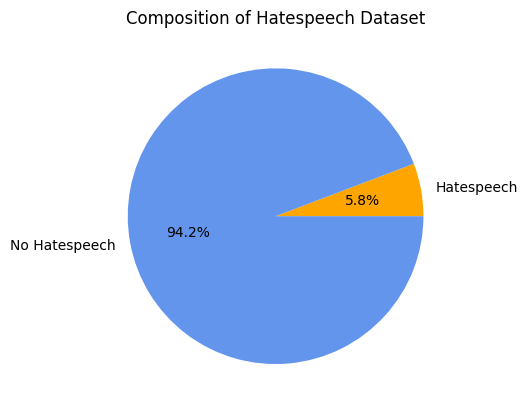

In [143]:
labels = 'Hatespeech', 'No Hatespeech'
sizes = [tweets_df['class'].value_counts()[0], tweets_df['class'].value_counts()[1]]

fig, ax = plt.subplots()
ax.pie(sizes, labels=labels,autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
ax.set_title("Composition of Hatespeech Dataset")
plt.show()

## Investigating How Accurate Filtering By Insults is

Why do we need a machine learning model to look for hatespeech and offensive language?
Here I will try the common strategy of simply flagging words known to be offensive by using a dataset of offensive words found on this github repository : 

In [144]:
import requests
import csv

CSV_URL="https://raw.githubusercontent.com/surge-ai/profanity/main/profanity_en.csv"

with requests.Session() as s:
    download = s.get(CSV_URL)

    decoded_content = download.content.decode('utf-8')

    cr = csv.reader(decoded_content.splitlines(), delimiter=',')
    my_list = list(cr)
insults_df=pd.DataFrame(my_list)
insults_df.columns = insults_df.iloc[0]
insults_df=insults_df[["text","canonical_form_1","category_1","severity_description"]]

tweets_df['tweet'] = tweets_df['tweet'].str.lower()
insults_df['text'] = insults_df['text'].str.lower()

severe_insults_df = insults_df[(insults_df["severity_description"] == "Severe")];

In [145]:
tweets_df['tweet'] = tweets_df['tweet'].str.lower()
insults_df['text'] = insults_df['text'].str.lower()

def find_first_insult(tweet, df):
    words = tweet.split(" ")
    # print(tweet)
    insults = []
    for word in words:
        word = word.strip()
        if df['text'].isin([word]).any():
            insults.append(word)
    if len(insults) > 0:
        return insults
    else:
        return None
    
def contains_insult(tweet, df):
    words = tweet.split(" ")
    for word in words:
        word = word.strip()
        if df['text'].isin([word]).any():
            return True
    return False


# find insults in each tweet
tweets_df['contains_insult'] = tweets_df['tweet'].apply(lambda x: find_first_insult(x,insults_df))
tweets_df['contains_severe_insult'] = tweets_df['tweet'].apply(lambda x: contains_insult(x,severe_insults_df))

# Filter tweets containing insults from the insult dataset
hatespeech_tweets = tweets_df[tweets_df['class'] == 0]
no_hatespeech_tweets = tweets_df[tweets_df['class'] == 1];

In [146]:

insult_hatespeech_categories = {}
insult_no_hatespeech_categories = {}

def category_of_insults(insult_list, df, hatespeech = True):
    global insult_hatespeech_categories
    global insult_no_hatespeech_categories
    categories = []
    if insult_list == None:
        return None
    for insult in insult_list:
        if not df['text'].isin([insult]).any():
            continue
        row = df[df['text'].str.contains(insult)].iloc[0]['category_1']
        category = row.strip()
        if category == 'category_1':
            continue
        categories.append(category)
        if hatespeech:
            if category in insult_hatespeech_categories:
                insult_hatespeech_categories[category] += 1
            else:
                insult_hatespeech_categories[category] = 1
        else:
            if category in insult_no_hatespeech_categories:
                insult_no_hatespeech_categories[category] += 1
            else:
                insult_no_hatespeech_categories[category] = 1
    if len(categories) == 0:
        categories = None
    return categories

hatespeech_tweets['category'] = hatespeech_tweets['contains_insult'].apply(lambda x: category_of_insults(x,severe_insults_df, True))
no_hatespeech_tweets['category'] = no_hatespeech_tweets['contains_insult'].apply(lambda x: category_of_insults(x,severe_insults_df, False))


/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_84529/2867321516.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hatespeech_tweets['category'] = hatespeech_tweets['contains_insult'].apply(lambda x: category_of_insults(x,severe_insults_df, True))
/var/folders/56/lnrgwj295yq6l00hqdbfzfmr0000gn/T/ipykernel_84529/2867321516.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  no_hatespeech_tweets['category'] = no_hatespeech_tweets['contains_insult'].apply(lambda x: category_of_insults(x,severe_i

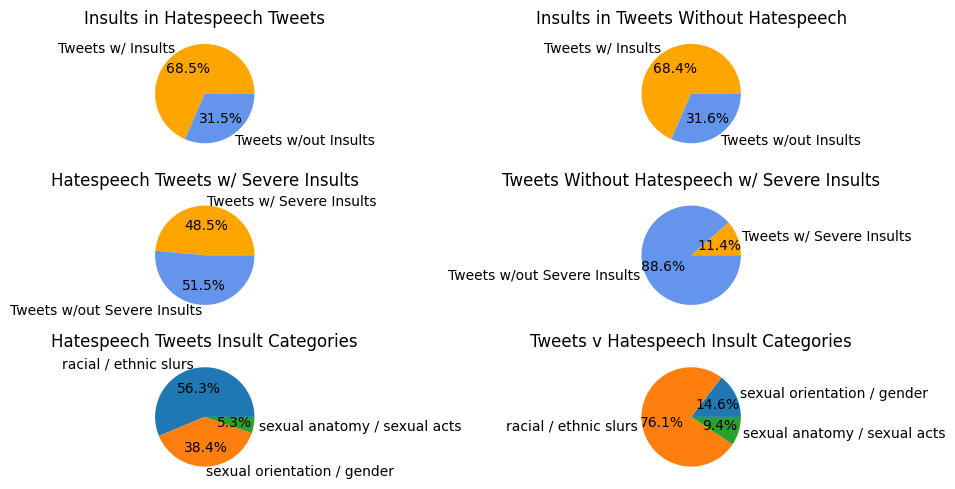

In [151]:
# Count the number of tweets with and without insults for hatespeech and no_hatespeech tweets
no_insults_hatespeech_count = hatespeech_tweets['contains_insult'].isna().sum()
no_insults_no_hatespeech_count = no_hatespeech_tweets['contains_insult'].isna().sum()

# Count the number of tweets without severe insults for hatespeech and no_hatespeech tweets
severe_hatespeech_count = (hatespeech_tweets['contains_severe_insult'] == True).sum()
no_severe_hatespeech_count = (hatespeech_tweets['contains_severe_insult'] == False).sum()

severe_no_hatespeech_count = (no_hatespeech_tweets['contains_severe_insult'] == True).sum()
no_severe_no_hatespeech_count = (no_hatespeech_tweets['contains_severe_insult'] == False).sum()

# Plotting pie charts
fig, axs = plt.subplots(3, 2, figsize=(10, 5))

# Pie chart for offensive tweets
axs[0][0].pie([hatespeech_tweets['contains_insult'].size - no_insults_hatespeech_count, no_insults_hatespeech_count], 
       labels=['Tweets w/ Insults', 'Tweets w/out Insults'],autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
axs[0][0].set_title('Insults in Hatespeech Tweets')

# Pie chart for no_hatespeech tweets
axs[0][1].pie([no_hatespeech_tweets['contains_insult'].size - no_insults_no_hatespeech_count, no_insults_no_hatespeech_count], 
       labels=['Tweets w/ Insults', 'Tweets w/out Insults'],autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
axs[0][1].set_title('Insults in Tweets Without Hatespeech')

axs[1][0].pie([severe_hatespeech_count, no_severe_hatespeech_count],
              labels=['Tweets w/ Severe Insults','Tweets w/out Severe Insults'],autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
axs[1][0].set_title('Hatespeech Tweets w/ Severe Insults')

axs[1][1].pie([severe_no_hatespeech_count, no_severe_no_hatespeech_count],
              labels=['Tweets w/ Severe Insults','Tweets w/out Severe Insults'],autopct='%1.1f%%',colors=['orange', 'cornflowerblue'])
axs[1][1].set_title('Tweets Without Hatespeech w/ Severe Insults')

axs[2][0].pie([x for x in insult_hatespeech_categories.values()],
              labels=[x for x in insult_hatespeech_categories.keys()], autopct='%1.1f%%')
axs[2][0].set_title('Hatespeech Tweets Insult Categories')

axs[2][1].pie([x for x in insult_no_hatespeech_categories.values()],
              labels=[x for x in insult_no_hatespeech_categories.keys()], autopct='%1.1f%%')
axs[2][1].set_title('Tweets v Hatespeech Insult Categories')

plt.tight_layout()
plt.show()

# Create pie chart

# Extract category labels and frequencies
# insult_hatespeech_categories
# insult_no_hatespeech_categories
categories_hatespeech_insults = list(insult_hatespeech_categories.keys())
frequencies_hatespeech_insults = list(insult_hatespeech_categories.values())

categories_no_hatespeech_insults = list(insult_no_hatespeech_categories.keys())
frequencies_no_hatespeech_insults = list(insult_no_hatespeech_categories.values())


### Flagging Occurances of Specific Slurs As a Strategy for Labeling Hatespeech

Simply flagging for offensive words or swears in tweets, ignoring the context they exist in, is a possible approach that we can take in order to identify tweets as containing hatespeech or not. But this approach may not be sufficient to accurately flag tweets. 

The same proportion of hatespeech tweets and normal tweets contain insults / offensive language, to a tenth of a percentage. This shows that by simply flagging tweets as hatespeech for containing insults in general, we would mislabel 31.6% of normal tweets as hatespeech, and mislabel 31.5% of hatespeech tweets as not containing hatespeech. We would mislabel normal tweets and hatespeech tweets at exactly the same rate.

For tweets that contain insults or strong language, both hatespeech and not hatespeech tweets have similar makeups in terms of the category of the insult. All three have racial / ethnic slurs, sexual orientation / gender, and sexual anatomy / sexual acts as their top three categories of insult, in that order. Although, hatespeech tweets that contain insults do contain slightly less racial/ethnic slurs than not hatespeech tweets that contain insults.

Although hatespeech tweets disproportionately contain slurs labeled as "severe" in comparison to normal tweets, almost half of all hatespeech tweets do not contain "severe" language. Additionally, 11.4% of normal tweets also contain this "severe" language. Flagging all severe language would surely result in a large proportion of normal tweets, not containing hatespeech, in being flagged as hatespeech. This could become problematic, especially if these specific terms are being used in the context of social justice. If we label all tweets containing severe language as hatespeech, over half of all hatespeech tweets will not be labeled correctly.

### Machine Learning May Improve Our Odds

We believe that we can improve upon this strategy of flagging hatespeech by, instead of searching for particular phrases and words, utilizing machine learning algorithms to label text as containing hatespeech or not. This would allow for models to take into consideration the context surrounding the usage of the terms and insults, and hopefully allow for a more effective algorithm.